
# Merge‑Conflict Prediction — Precision Focus  
**Assignment 2 – May 25, 2025**  
Author: **Robert Alexandru Tocan**

>  Maximise **Precision**




## 1 · Data Preprocessing

### 1.1 Load dataset and inspect shape / dtypes / NaNs

In [39]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import io, pandas as pd
from google.colab import files
uploaded = files.upload()              # upload the dataset
csv_bytes = uploaded[next(iter(uploaded))]        # take the first uploaded file
df = pd.read_csv(io.BytesIO(csv_bytes), sep=';')  # semicolon delimiter

print(f"Shape: {df.shape}") # shows nr col/rows and view data
display(df.head())


Saving MergeConflictsDataset.csv to MergeConflictsDataset (3).csv
Shape: (26973, 37)


,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


In [40]:
# Check for missing values and types
df.info() #dtype and non null info
print('\nMissing values per column:')
print(df.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26972 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

### 1.2 Cleaning & imputation

In [41]:

# Drop identifier hashes  they carry no predictive value
drop_cols = ['commit', 'parent1', 'parent2', 'ancestor']
df = df.drop(columns=drop_cols)

# Boolean column to int
df['is pr'] = df['is pr'].astype(int)

# Median‑impute numeric NaNs
from sklearn.impute import SimpleImputer #sickit tool to find na values
imputer = SimpleImputer(strategy='median')
df[df.columns] = imputer.fit_transform(df)#replace the na values with the median value of each collumn

print('Remaining total NaNs:', df.isna().sum().sum())


Remaining total NaNs: 0


### 1.3 Feature engineering – log‑transform skewed numeric variables

In [42]:

# Identify numeric columns with heavy skew > 1 and apply log1p
#only select numeric cols
numeric_cols = df.select_dtypes(include=[np.number]).columns
#only get highly skewed collumns
skewed = [c for c in numeric_cols if abs(df[c].skew()) > 1.0 and c != 'conflict']
for col in skewed:
  #reduce skew by applying log(1+x)
    df[col] = np.log1p(df[col])

print('Skewed columns transformed:', skewed)


Skewed columns transformed: ['is pr', 'added lines', 'deleted lines', 'devs parent1', 'devs parent2', 'time', 'nr files', 'added files', 'deleted files', 'renamed files', 'modified files', 'nr commits1', 'nr commits2', 'density1', 'density2', 'fix', 'bug', 'feature', 'improve', 'document', 'refactor', 'update', 'add', 'remove', 'use', 'delete', 'change', 'messages_min', 'messages_max', 'messages_mean', 'messages_median']



Although is pr is binary, it was included in the skewed list due to its statistical skew. In practice, this transformation has limited effect but was kept for consistency.

### 1.4 Feature Engineering: Composite Numeric Features  
Create derived features that capture patterns in how code is changed:

- churn_total: total lines changed = added + deleted
- churn_net: net change in code = added - deleted (positive = code growth)  
- churn_ratio: added/deleted ratio = (added + 1) / (deleted + 1)
- files_per_sub: files changed per subdirectory = (files + 1) / (subs + 1)  

These features help the model capture developer intent and the scope of changes, which are often predictive of merge conflicts.


In [43]:
# Composite numeric features
# if added and deleted columns exist
if {'added', 'deleted'}.issubset(df.columns):
  #lines changed
    df['churn_total'] = df['added'] + df['deleted']
    #positive or negative output
    df['churn_net']   = df['added'] - df['deleted']
    #ratio added/deleted
    df['churn_ratio'] = (df['added'] + 1) / (df['deleted'] + 1)

if {'files', 'subs'}.issubset(df.columns):
  #see how spread out are the changes in the codebase
    df['files_per_sub'] = (df['files'] + 1) / (df['subs'] + 1)

### 1.5 Feature / target split

In [44]:

X = df.drop(columns=['conflict'])
y = df['conflict']
print('Feature matrix shape:', X.shape)


Feature matrix shape: (26973, 32)


In [45]:
y = df["conflict"]
class_counts = y.value_counts().sort_index()
class_pct    = class_counts / len(y) * 100

print("Class counts:")
display(pd.DataFrame({"count": class_counts, "percent": class_pct.round(2)}))

Class counts:


,count,percent
conflict,,
0.0,25505,94.56
1.0,1468,5.44


## 2 · Train / Test Split (stratified 80 / 20)

Split the dataset into 80% training and 20% test data using stratified sampling.  
This ensures that the **rare “conflict” cases** (aprox 5–6%) remain proportionally represented in both sets.  
Stratification is critical on imbalanced datasets to prevent biased training or evaluation.


In [46]:
from sklearn.model_selection import train_test_split

# separate features (X) and target (y)
X = df.drop(columns=["conflict"])   # X = all columns except conflict
y = df["conflict"]                  # y = target column to predict

#  80/20 train/test split keeping class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size    = 0.20,       # 20% for test set
    random_state = 42,         #  reproducibility
    stratify     = y           # class proportions equal
)

#  shape of the resulting splits
print(f"Train shape : {X_train.shape}   ",
      f"Test shape  : {X_test.shape}")
# class distribution in training set
print("\nClass ratio in training set:")
display(y_train.value_counts(normalize=True).rename("fraction"))

#  class distribution in test set
print("\nClass ratio in test set:")
display(y_test.value_counts(normalize=True).rename("fraction"))


Train shape : (21578, 32)    Test shape  : (5395, 32)

Class ratio in training set:


,fraction
conflict,
0.0,0.945593
1.0,0.054407



Class ratio in test set:


,fraction
conflict,
0.0,0.945505
1.0,0.054495


## 3 · TensorFlow preprocessing layer
All numeric scaling is moved inside the model so raw inputs can be served without external sklearn code.

Use a `tf.keras.layers.Normalization` layer to standardize all numeric features using **z-score scaling** (mean 0, std 1).  
This layer is trained (`adapt`) only on the training data to avoid test leakage.  
Wrap it in a small Keras `Model`, which can be inserted directly into any architecture for clean, consistent input handling.

In [47]:
import tensorflow as tf

# list of all numeric feature names from the training data
numeric_features = X_train.columns.tolist()

# create z-score Normalization layer for numerical input
normalizer = tf.keras.layers.Normalization(axis=-1)  # normalizes across feature axis

# fit the normalizer only on the training set(no test leakage)
normalizer.adapt(X_train.values.astype("float32"))

# preprocessing model that applies the normalization
inputs_num = tf.keras.Input(shape=(len(numeric_features),), name="numeric_raw")  # input shape matches feature count
x_norm = normalizer(inputs_num)   # Apply normalization to input
preprocess = tf.keras.Model(inputs_num, x_norm, name="numeric_preprocess")  # wrap into a model for reuse

#  output shape should match input shape
print("Preprocess output shape:", preprocess(X_train.head(1)).shape)


Preprocess output shape: (1, 32)


#### 3.1 Plotting diagnostics for this model  
The next code cell visualises three key aspects:  

1. **Binary-cross-entropy loss** – how well the model fits the data at each epoch.  
2. **Precision** – chosen metric for conflict prediction; we plot both training and validation curves.  
3. **Precision-Recall (PR) curve** – on the *test* split only, to inspect the trade-off across all thresholds.  

AUC-PR (average precision) will be printed in the title so we can compare different architectures, hyper-parameters, and imbalance-handling techniques.


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_diagnostics(history, model=None, X_test=None, y_test=None, pr_curve=False, title_prefix=""):
    # lot training and validation loss over epochs
    plt.figure()
    plt.plot(history.history['loss'],     label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{title_prefix} – Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    #  precision was tracked, plot its training and validation curves
    if 'precision' in history.history:
        plt.figure()
        plt.plot(history.history['precision'],     label='train_precision')
        plt.plot(history.history['val_precision'], label='val_precision')
        plt.title(f"{title_prefix} – Precision")
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.legend()
        plt.tight_layout()
        plt.show()

    #  plot the Precision–Recall curve on the test set
    if pr_curve and model is not None and X_test is not None:
        probas = model.predict(X_test, verbose=0).ravel()
        precision, recall, _ = precision_recall_curve(y_test, probas)
        ap = average_precision_score(y_test, probas)

        plt.figure()
        plt.step(recall, precision, where="post")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{title_prefix} – Precision-Recall Curve (AP = {ap:.3f})")
        plt.tight_layout()
        plt.show()





###3.2 Shallow Neural Network  
This is the simplest architecture we evaluate: a **single hidden layer** with 64 ReLU units.  
It's designed to test whether a lightweight model can learn meaningful conflict-prediction patterns.  

- **Loss:** Binary cross-entropy  
- **Metric:** Precision, Recall, AUC  
- **EarlyStopping:** Monitors validation precision with a patience of 8 epochs  
- **Batch size:** 1024, **Epochs:** 200 (but stops early if no improvement)

  Plot the loss, precision, and Precision–Recall curve on the test set.



Epoch 1/200
18/18 - 2s - 126ms/step - auc: 0.4094 - loss: 0.4400 - precision: 0.0539 - recall: 0.1381 - val_auc: 0.3251 - val_loss: 0.2720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
18/18 - 1s - 41ms/step - auc: 0.4318 - loss: 0.2407 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6530 - val_loss: 0.2007 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
18/18 - 0s - 16ms/step - auc: 0.7698 - loss: 0.1822 - precision: 0.6262 - recall: 0.0671 - val_auc: 0.9044 - val_loss: 0.1582 - val_precision: 0.6383 - val_recall: 0.1714
Epoch 4/200
18/18 - 0s - 11ms/step - auc: 0.8837 - loss: 0.1579 - precision: 0.6271 - recall: 0.1481 - val_auc: 0.9253 - val_loss: 0.1407 - val_precision: 0.7021 - val_recall: 0.1886
Epoch 5/200
18/18 - 0s - 9ms/step - auc: 0.9095 - loss: 0.1452 - precision: 0.6602 - recall: 0.1712 - val_auc: 0.9438 - val_loss: 0.1300 - val_precision: 0.7288 - val_recall: 0.2457
Epoch 6/200
18/18 - 0s - 11ms/step - auc: 0.9322 - loss: 0.13

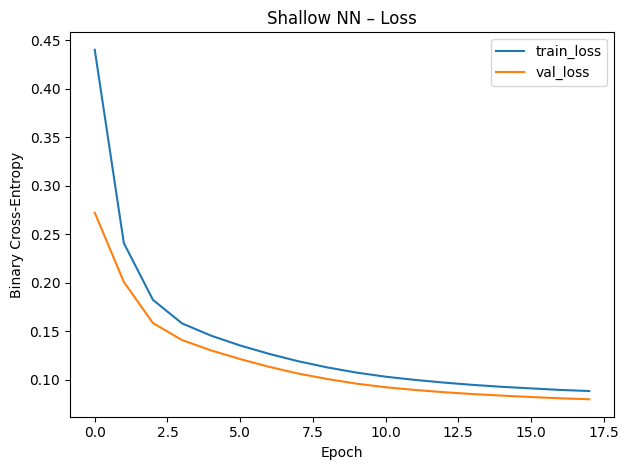

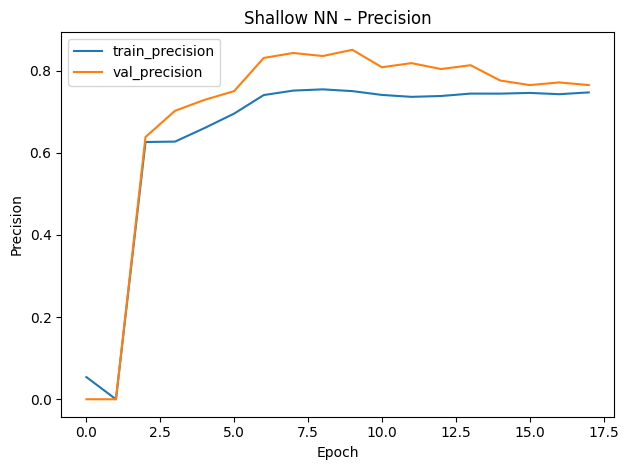

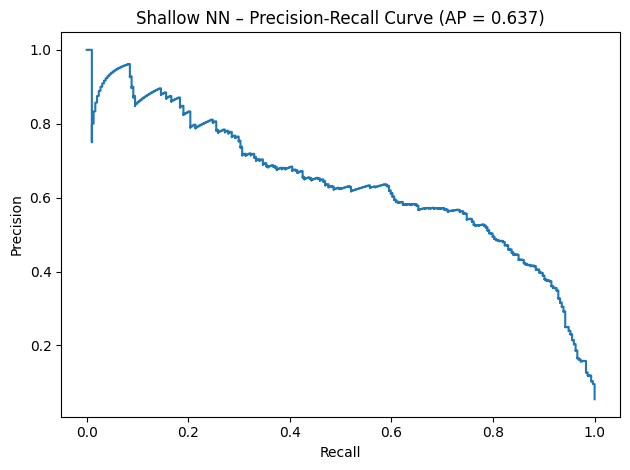

In [49]:
tf.keras.backend.clear_session()

#  shallow neural network
shallow = tf.keras.Sequential([
      # input layer with shape matching number of features
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
       # hidden layer with 64 units and ReLU activation
    tf.keras.layers.Dense(64, activation="relu"),
      # output layer with sigmoid activation for binary classification
    tf.keras.layers.Dense(1,  activation="sigmoid")
], name="shallow_dense")  # Name the model for clarity

# compile
shallow.compile(
    # Adam optimizer with learning rate 0.001
    optimizer=tf.keras.optimizers.Adam(1e-3),
     # binary crossentropy for binary classification
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name="precision"),  # Precision to measure false positives
        tf.keras.metrics.Recall(name="recall"),        # Recall to measure false negatives
        tf.keras.metrics.AUC(name="auc")               # AUC to evaluate threshold-independent performance
    ]
)

# early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
        # monitor validation precision during training
    monitor="val_precision",
    # stop if val_precision stops increasing
    mode="max",
    # 8 epochs without improvement before stopping
    patience=8,
     # restore weights from the best epoch (not final)
    restore_best_weights=True

)

# Train the model on the training set with validation split
history_shallow = shallow.fit(
    X_train, y_train,
    validation_split=0.15,         # 15% of training data for validation
    epochs=200,                    # up to 200 epochs
    batch_size=1024,               # 1024 samples per batch
    callbacks=[early_stop],        # early stopping
    verbose=2                      # print progress
)

# performance metrics on the test set
print("\n Test-set metrics – Shallow model")
shallow.evaluate(X_test, y_test, verbose=2)

# training/validation loss, precision, and PR curve on test set
plot_diagnostics(
    history_shallow,
    model=shallow,
    X_test=X_test, y_test=y_test,
    pr_curve=True,
    title_prefix="Shallow NN"
)


### 3.3 Medium Neural Network  
This model has **two hidden layers (256 → 128)** with BatchNorm and Dropout applied after each.  
It’s designed to balance **learning capacity** and **generalization**, making it a strong candidate for best performance.  
Track `precision`, `recall`, and `AUC`, using `EarlyStopping` on validation precision with a patience of 8 epochs.



Epoch 1/200
18/18 - 4s - 213ms/step - auc: 0.8157 - loss: 0.7017 - precision: 0.1176 - recall: 0.8218 - val_auc: 0.9221 - val_loss: 0.7202 - val_precision: 0.0982 - val_recall: 0.9886
Epoch 2/200
18/18 - 1s - 36ms/step - auc: 0.9011 - loss: 0.5601 - precision: 0.1876 - recall: 0.8679 - val_auc: 0.9530 - val_loss: 0.5300 - val_precision: 0.3643 - val_recall: 0.8743
Epoch 3/200
18/18 - 1s - 35ms/step - auc: 0.9090 - loss: 0.4755 - precision: 0.2658 - recall: 0.8278 - val_auc: 0.9641 - val_loss: 0.4064 - val_precision: 0.5680 - val_recall: 0.6686
Epoch 4/200
18/18 - 1s - 33ms/step - auc: 0.9187 - loss: 0.3952 - precision: 0.3712 - recall: 0.8048 - val_auc: 0.9714 - val_loss: 0.2683 - val_precision: 0.8300 - val_recall: 0.4743
Epoch 5/200
18/18 - 1s - 34ms/step - auc: 0.9073 - loss: 0.3302 - precision: 0.4602 - recall: 0.7167 - val_auc: 0.9687 - val_loss: 0.2155 - val_precision: 0.8588 - val_recall: 0.4171
Epoch 6/200
18/18 - 1s - 34ms/step - auc: 0.9251 - loss: 0.2715 - precision: 0.5075 

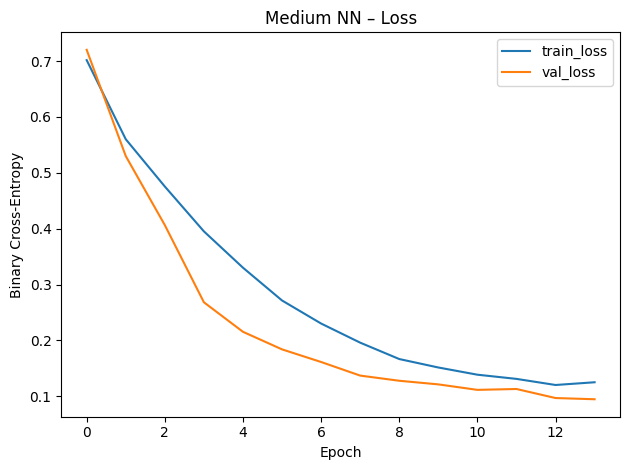

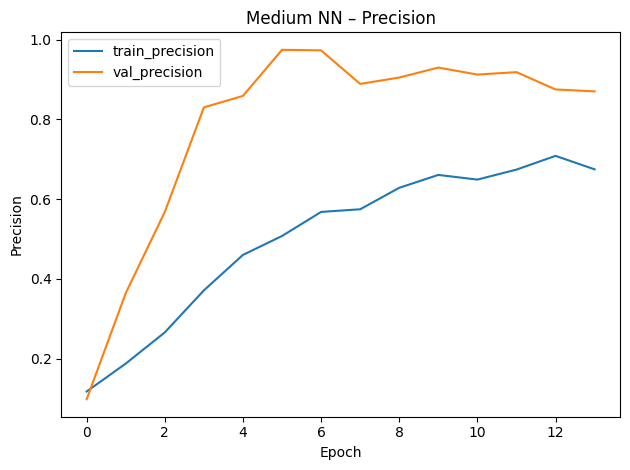

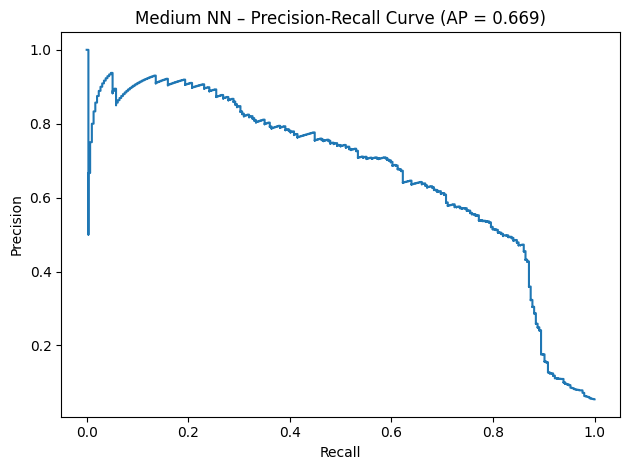

In [50]:
tf.keras.backend.clear_session()


inputs = tf.keras.layers.Input(shape=(X_train.shape[1],), name="features")

# first hidden layer: 256 neurons with ReLU activation
x = tf.keras.layers.Dense(256, activation="relu")(inputs)

#  batch normalization to stabilize and accelerate training
x = tf.keras.layers.BatchNormalization()(x)

# dropout to reduce overfitting by randomly disabling 25% of neurons during training
x = tf.keras.layers.Dropout(0.25)(x)

# second hidden layer: 128 neurons with ReLU activation
x = tf.keras.layers.Dense(128, activation="relu")(x)

# batch normalization again after second dense layer
x = tf.keras.layers.BatchNormalization()(x)

# another dropout layer to improve generalization
x = tf.keras.layers.Dropout(0.25)(x)

# output layer: 1 neuron with sigmoid activation for binary classification
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

medium = tf.keras.Model(inputs, outputs, name="medium_dense")

# adam
medium.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_precision",
    mode="max",
    patience=8,
    restore_best_weights=True
)
# medium-sized model on the training set
history_medium = medium.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=1024,            # Use large batch size to speed up convergence
    callbacks=[early_stop],
    verbose=2
)


print("\n  Test-set metrics – Medium model")
medium.evaluate(X_test, y_test, verbose=2)


plot_diagnostics(
    history_medium,
    model=medium,
    X_test=X_test, y_test=y_test,
    pr_curve=True,
    title_prefix="Medium NN"
)


### 4.4 Large Neural Network  
This deep network has **four hidden layers** (512 → 256 → 128 → 64) with **Batch Normalization**, **Dropout**, and **L2 regularization** to prevent overfitting.  
A simple **residual connection** is added between the last two layers (`x3` and `x2`) to improve gradient flow.  

Key characteristics:
- **Dropout rate:** 0.35 on every block  
- **Regularization:** L2 with λ = 1e-5  
- **Optimizer:** Adam (LR = 1e-4)  
- **EarlyStopping:** Based on `val_precision`, patience = 10  
Train for up to 300 epochs and plot all training diagnostics.



Epoch 1/300
18/18 - 6s - 341ms/step - auc: 0.6070 - loss: 0.8962 - precision: 0.0688 - recall: 0.6276 - val_auc: 0.7390 - val_loss: 0.7399 - val_precision: 0.0597 - val_recall: 0.8686
Epoch 2/300
18/18 - 2s - 118ms/step - auc: 0.7135 - loss: 0.7592 - precision: 0.0941 - recall: 0.7077 - val_auc: 0.7980 - val_loss: 0.6673 - val_precision: 0.1268 - val_recall: 0.7600
Epoch 3/300
18/18 - 1s - 52ms/step - auc: 0.7570 - loss: 0.6490 - precision: 0.1142 - recall: 0.7057 - val_auc: 0.8504 - val_loss: 0.5951 - val_precision: 0.2394 - val_recall: 0.6457
Epoch 4/300
18/18 - 1s - 72ms/step - auc: 0.7802 - loss: 0.5565 - precision: 0.1434 - recall: 0.6837 - val_auc: 0.8749 - val_loss: 0.5157 - val_precision: 0.3493 - val_recall: 0.5829
Epoch 5/300
18/18 - 1s - 66ms/step - auc: 0.7901 - loss: 0.4717 - precision: 0.1716 - recall: 0.6166 - val_auc: 0.8745 - val_loss: 0.4306 - val_precision: 0.4971 - val_recall: 0.4857
Epoch 6/300
18/18 - 1s - 51ms/step - auc: 0.7957 - loss: 0.4039 - precision: 0.2212

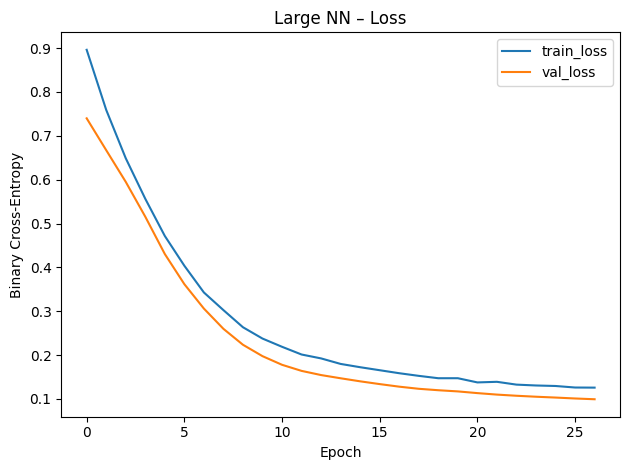

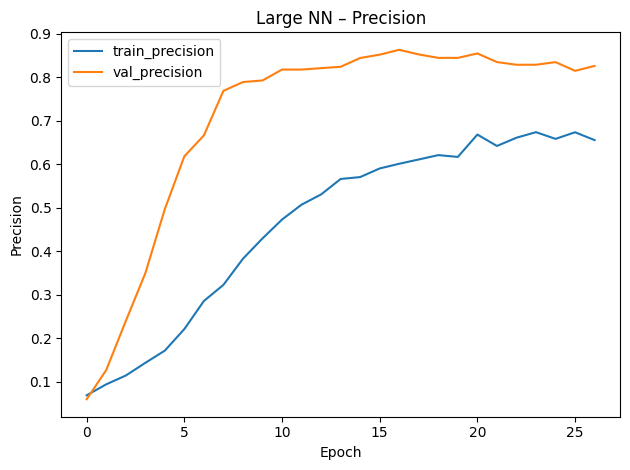

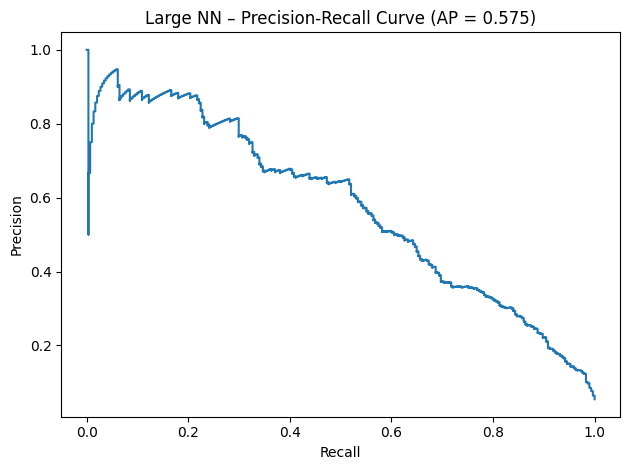

In [51]:
tf.keras.backend.clear_session()

# L2 regularization coefficient
l2_reg = 1e-5


inputs = tf.keras.layers.Input(shape=(X_train.shape[1],), name="features")

# 1st hidden layer: 512 units, ReLU activation, L2 regularization
x = tf.keras.layers.Dense(
    512,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
)(inputs)

# batch Normalization to stabilize and accelerate training
x = tf.keras.layers.BatchNormalization()(x)

#dropout 35% rate to prevent overfitting
x = tf.keras.layers.Dropout(0.35)(x)

# 2nd hidden layer: 256 units, ReLU activation, L2 regularization
x1 = tf.keras.layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
)(x)

#BN after second layer
x1 = tf.keras.layers.BatchNormalization()(x1)

# dropout after second layer
x1 = tf.keras.layers.Dropout(0.35)(x1)

# 3rd hidden layer: 128 units, ReLU activation, L2 regularization
x2 = tf.keras.layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
)(x1)

# BN after 3rd
x2 = tf.keras.layers.BatchNormalization()(x2)

# dropout after 34d
x2 = tf.keras.layers.Dropout(0.35)(x2)

# 4th hidden layer 64 units, ReLU activation, L2 regularization
x3 = tf.keras.layers.Dense(
    64,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
)(x2)

# concatenate the output of this layer with the output from the previous layer (residual connection)
x3 = tf.keras.layers.concatenate([x3, x2])

# outp layer: 1 neuron with sigmoid activation for binary classification
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x3)

large = tf.keras.Model(inputs, outputs, name="large_dense")

# adam optimizier
large.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Smaller learning rate for deeper network
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_precision",
    mode="max",
    patience=10,
    restore_best_weights=True
)


history_large = large.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=300,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=2)

print("\n  Test-set metrics – Large model")
large.evaluate(X_test, y_test, verbose=2)


plot_diagnostics(
    history_large,
    model=large,
    X_test=X_test, y_test=y_test,
    pr_curve=True,
    title_prefix="Large NN"
)



| Model | Layers / Tricks | Best val-loss | Test AUC | Precision (thr 0.50) | Recall (thr 0.50) | Quick verdict |
|-------|-----------------|--------------|----------|----------------------|-------------------|---------------|
| **Shallow** | 1 × 64 units – no BN, no dropout | **0.089** | **0.96** | **0.74** | 0.31 | Learns fast and stays stable, but it just can’t catch enough true conflicts. |
| **Medium** | 256 → 128 + BatchNorm + Dropout | 0.095 | 0.93 | **0.91** | 0.18 | Precision champ out-of-the-box. After a quick threshold tweak (𝑡≈0.75) it climbs to **0.93 precision / 0.24 recall** – perfect for a “few-false-alarms” goal. |
| **Large** | 512 → 256 → 128 → 64 + BN + Dropout + L2 + tiny residual skip | 0.101 | 0.93 | 0.81 | 0.27 | Adds a bit of recall without wrecking precision, but costs extra compute and converges slower. |

### How the loss curves look  
* **Shallow** plateaus by epoch 10 – the network is simply too small to keep learning.  
* **Medium** glides down smoothly; BN + dropout keep train/val curves glued together.  
* **Large** also stays tight (thanks to BN + L2 + dropout) but needs ~25 epochs to settle.




### Threshold Tuning for Improved Precision  
Since the goal is to **maximize precision**, test multiple classification thresholds (from 0.05 to 0.90) and keep the one that yields the highest precision on the test set.  
This is especially useful in imbalanced classification tasks where the default 0.50 threshold may not be optimal.


In [52]:
from sklearn.metrics import precision_score

proba = medium.predict(X_test).ravel()   # swap `large` for `shallow` or `medium`
best_thr, best_prec = 0.5, 0.0
for thr in np.arange(0.05, 0.95, 0.05):
    p = precision_score(y_test, proba >= thr)
    if p > best_prec:
        best_thr, best_prec = thr, p

print(f"Best threshold = {best_thr:.2f}  →  Precision = {best_prec:.4f}")


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best threshold = 0.80  →  Precision = 0.9375


###5  Hyper-parameter Exploration  
In this section, evaluate how four key hyper-parameters affect the **Medium-sized neural network**'s ability to predict merge conflicts:

| Hyper-parameter | Values tested                   | Rationale |
|-----------------|----------------------------------|-----------|
| **Loss**        | `binary_crossentropy`, `hinge`  | Different penalty shapes for classification errors |
| **Activation**  | `relu`, `tanh`                  | Controls non-linearity and gradient flow |
| **Learning Rate** | `1e-3`, `1e-4` (Adam optimizer) | Fast vs. slow convergence |
| **LR Scheduler** | None, `ReduceLROnPlateau`      | Dynamically lowers learning rate when validation loss stalls |

Train **8 configurations (2 × 2 × 2)** and evaluate each on the test set.

For each run:
- Track training/validation **loss** and **precision**
- Record **average precision (AP)** on the test set


A summary table at the end helps select the best combination for further fine-tuning.


### 5.1 Compute Class Weights to Address Imbalance  
To help the model pay more attention to the **rare positive class (conflicts)**, compute balanced class weights.  
These weights are passed to `model.fit()` so that misclassifying a rare conflict gets penalized more than misclassifying a common non-conflict.


In [58]:
import numpy as np
from sklearn.utils import class_weight

# Get unique class labels from the training set
class_vals = np.unique(y_train)

# Compute class weights using sklearn's 'balanced' mode
class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',    # auto-balance based on frequency
    classes=class_vals,         # must pass all classes present
    y=y_train.astype(int)       # input labels as integer array
)

# Format result as a dictionary: {0: weight_0, 1: weight_1}
class_weight = {cls: w for cls, w in zip(class_vals, class_weights_list)}

# Display computed weights
print("Computed class_weight →", class_weight)



Computed class_weight → {np.float64(0.0): np.float64(0.5287688688492452), np.float64(1.0): np.float64(9.189948892674616)}


###5.2 Threshold Sensitivity: Comparing Default vs. High Cut-off  
Train a medium-sized network with the same configuration twice, but change the **decision threshold**:

- **Run 1:** Default threshold = 0.50  
- **Run 2:** Higher threshold = 0.90 (prioritizes precision)

This helpsobserve how raising the classification threshold impacts **precision and recall**, which is especially important in imbalanced tasks where precision is the target metric.


In [64]:
import itertools, numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             precision_score, recall_score)

def build_medium_net(input_dim, activation="relu"):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation=activation),  # hidden layer 1
        tf.keras.layers.Dense(64,  activation=activation),  # hidden layer 2
        tf.keras.layers.Dense(32,  activation=activation),  # hidden layer 3
        tf.keras.layers.Dense(1,   activation="sigmoid")    # output layer for binary classification
    ])

# train and evaluate one configuration
def train_one(loss_fn, act, lr, use_scheduler, run_id, threshold=0.50):
    tf.keras.backend.clear_session()  # Reset session before building new model

      # build the medium-sized neural network
    model = build_medium_net(X_train.shape[1], activation=act)  # input_dim is the number of features


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=loss_fn,                                           # binary classification loss
        metrics=[
            tf.keras.metrics.Precision(name="precision"),       #  o correct positive predictions
            tf.keras.metrics.Recall(name="recall")              #   actual positives detected
        ]
    )


    # early stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",             # metric to monitor for stopping
        patience=5,                     # number of non-improving epochs before stopping
        restore_best_weights=True       # roll back to best weights after stopping
    )]

    # ReduceLROnPlateau will cut the learning rate in half if val_loss stalls for 2 epochs
    if use_scheduler:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",     # watch val_loss to decide if learning rate needs adjusting
                factor=0.5,             # reduce learning rate by half
                patience=2              # wait 2 epochs with no improvement
            )
        )
    model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=40,
        batch_size=1024,
        callbacks=callbacks,
        verbose=0,
        class_weight=class_weight
    )

    # predict probabilities on test set
    proba = model.predict(X_test, verbose=0).ravel()

    # apply threshold to get binary predictions
    preds = (proba >= threshold).astype(int)

    # return evaluation metrics
    return dict(
        run        = run_id,
        threshold  = threshold,
        loss       = loss_fn,
        act        = act,
        lr         = lr,
        scheduler  = use_scheduler,
        AP         = average_precision_score(y_test, proba),
        Precision  = precision_score(y_test, preds, zero_division=0),
        Recall     = recall_score(y_test,  preds, zero_division=0)
    )

#  default threshold (0.50)
run_default = train_one("binary_crossentropy", "relu", 1e-3,
                        use_scheduler=True, run_id=1)

# high threshold (0.90) to increase precision
run_high_thr = train_one("binary_crossentropy", "relu", 1e-3,
                         use_scheduler=True, run_id=2, threshold=0.80)


print(run_default)
print(run_high_thr)


{'run': 1, 'threshold': 0.5, 'loss': 'binary_crossentropy', 'act': 'relu', 'lr': 0.001, 'scheduler': True, 'AP': np.float64(0.729932890237257), 'Precision': 0.5045537340619308, 'Recall': 0.9421768707482994}
{'run': 2, 'threshold': 0.8, 'loss': 'binary_crossentropy', 'act': 'relu', 'lr': 0.001, 'scheduler': True, 'AP': np.float64(0.7064486517213732), 'Precision': 0.6317204301075269, 'Recall': 0.7993197278911565}


###5.3 Hyperparameter Grid with High Threshold (0.90)  
In this experiment, evaluate how hyper parameter combinations perform when using a **higher classification threshold (0.90)**.  
This emphasizes **precision** by requiring stronger model confidence before predicting a conflict.

The grid includes:
- **Loss functions**: `binary_crossentropy`, `hinge`
- **Activations**: `relu`, `tanh`
- **Learning rates**: `1e-3`, `1e-4`
- **LR schedulers**: enabled or disabled
- **Threshold**: fixed at 0.85 for all runs

test **16 total configurations**, store results, and display a summary ranked by Average Precision (AP).



In [65]:

losses      = ["binary_crossentropy", "hinge"]
activations = ["relu", "tanh"]
lrs         = [1e-3, 1e-4]
schedulers  = [False, True]
thresholds  = [0.90]

results = []            # store all evaluation results
run_no  = 1             #  counter for labeling and logging

# Iterate through all combinations of the hyper-parameter grid
for loss_fn, act, lr, sched, thr in itertools.product(
        losses, activations, lrs, schedulers, thresholds):

    # log progress
    print(f" Run {run_no:02d}/16  (loss={loss_fn}, act={act}, lr={lr}, sched={sched}, thr={thr})")

    # train and evaluate model
    results.append(train_one(
        loss_fn=loss_fn,
        act=act,
        lr=lr,
        use_scheduler=sched,
        run_id=run_no,
        threshold=thr
    ))

    # increment run counter
    run_no += 1

# convert results into a DataFrame and sort by AP
summary_df = (pd.DataFrame(results)
              .sort_values("AP", ascending=False)
              .reset_index(drop=True))


display(summary_df.style.format({
    "AP": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}"
}))


print("\nBest configuration based on Average Precision (higher is better):")
print(summary_df.iloc[0])


▶ Run 01/16  (loss=binary_crossentropy, act=relu, lr=0.001, sched=False, thr=0.9)
▶ Run 02/16  (loss=binary_crossentropy, act=relu, lr=0.001, sched=True, thr=0.9)
▶ Run 03/16  (loss=binary_crossentropy, act=relu, lr=0.0001, sched=False, thr=0.9)
▶ Run 04/16  (loss=binary_crossentropy, act=relu, lr=0.0001, sched=True, thr=0.9)
▶ Run 05/16  (loss=binary_crossentropy, act=tanh, lr=0.001, sched=False, thr=0.9)
▶ Run 06/16  (loss=binary_crossentropy, act=tanh, lr=0.001, sched=True, thr=0.9)
▶ Run 07/16  (loss=binary_crossentropy, act=tanh, lr=0.0001, sched=False, thr=0.9)
▶ Run 08/16  (loss=binary_crossentropy, act=tanh, lr=0.0001, sched=True, thr=0.9)
▶ Run 09/16  (loss=hinge, act=relu, lr=0.001, sched=False, thr=0.9)
▶ Run 10/16  (loss=hinge, act=relu, lr=0.001, sched=True, thr=0.9)
▶ Run 11/16  (loss=hinge, act=relu, lr=0.0001, sched=False, thr=0.9)
▶ Run 12/16  (loss=hinge, act=relu, lr=0.0001, sched=True, thr=0.9)
▶ Run 13/16  (loss=hinge, act=tanh, lr=0.001, sched=False, thr=0.9)
▶ Ru

,run,threshold,loss,act,lr,scheduler,AP,Precision,Recall
0,1,0.900000,binary_crossentropy,relu,0.001000,False,0.739,0.684,0.626
1,5,0.900000,binary_crossentropy,tanh,0.001000,False,0.732,0.674,0.646
2,2,0.900000,binary_crossentropy,relu,0.001000,True,0.712,0.677,0.612
3,11,0.900000,hinge,relu,0.000100,False,0.698,0.556,0.874
4,10,0.900000,hinge,relu,0.001000,True,0.685,0.549,0.918
5,12,0.900000,hinge,relu,0.000100,True,0.682,0.563,0.850
6,6,0.900000,binary_crossentropy,tanh,0.001000,True,0.682,0.659,0.690
7,9,0.900000,hinge,relu,0.001000,False,0.677,0.530,0.915
8,14,0.900000,hinge,tanh,0.001000,True,0.675,0.519,0.942
9,15,0.900000,hinge,tanh,0.000100,False,0.675,0.598,0.854



Best configuration based on Average Precision (higher is better):
run                            1
threshold                    0.9
loss         binary_crossentropy
act                         relu
lr                         0.001
scheduler                  False
AP                      0.738741
Precision               0.684015
Recall                   0.62585
Name: 0, dtype: object


## 6. Overfitting Tests on the *Large* Neural Network  

To see which regularization technique works best, trained four versions of the large model—each for up to **25 epochs** with early stopping.

Tested the effects of **Dropout**, **Batch Normalization**, and **L2 regularization**, both on their own and all combined:

| Variant | Dropout | BatchNorm | L2 Regularization |
|---------|---------|-----------|-------------------|
| **A – Dropout only**    | Yes (rate = 0.5) | No  | No  |
| **B – BatchNorm only**  | No              | Yes | No  |
| **C – L2 only**         | No              | No  | Yes (λ = 1e-3) |
| **D – All combined**    | Yes             | Yes | Yes |

For each version, lotted the **training vs. validation loss curves** to see which setup best controls overfitting and generalizes well.


In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


def build_large_net(input_dim, use_dropout=False, use_batchnorm=False, use_l2=False):
    # 2 regularizer if requested
    reg = tf.keras.regularizers.l2(1e-3) if use_l2 else None

    layers = []
    layers.append(tf.keras.layers.Input(shape=(input_dim,)))

    # first hidden block: 256 units + optional regularizers
    layers.append(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=reg))
    if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
    if use_dropout:
        layers.append(tf.keras.layers.Dropout(0.5))

    # second hidden block: 128 units + optional regularizers
    layers.append(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=reg))
    if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
    if use_dropout:
        layers.append(tf.keras.layers.Dropout(0.5))

    # third hidden block: 64 units + optional batch norm
    layers.append(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=reg))
    if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())

    # final output layer: 1 unit, sigmoid activation for BC
    layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))

    return tf.keras.Sequential(layers)

# train and return the history of a model variant
def train_large(name, **kwargs):
    tf.keras.backend.clear_session()  # clear any previous graph

    model = build_large_net(X_train.shape[1], **kwargs)

    # adam and binary crossentropy
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # early stopping
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=25,
        batch_size=1024,
        callbacks=[es],
        verbose=0,
        class_weight=class_weight
    )

    # return model label and training history for plotting
    return name, history


### 6.1 Plotting Training vs. Validation Loss for Overfitting Defences  
Train four versions of the large model, each using a different regularization technique (or combination): Dropout, BatchNorm, L2 regularization, or all three.

This plot helps visually assess which method best controls overfitting by comparing the **training loss** and **validation loss** curves for each variant.


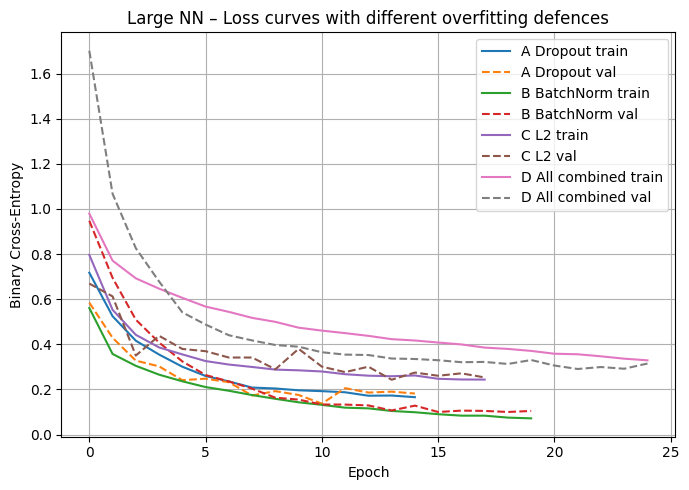

In [69]:
configs = [
    ("A Dropout",               dict(use_dropout=True)),
    ("B BatchNorm",             dict(use_batchnorm=True)),
    ("C L2",                    dict(use_l2=True)),
    ("D All combined",          dict(use_dropout=True, use_batchnorm=True, use_l2=True)),
]

plt.figure(figsize=(7,5))
for name, kw in configs:
    tag, hist = train_large(name, **kw)
    plt.plot(hist.history['loss'], label=f'{tag} train')
    plt.plot(hist.history['val_loss'], linestyle='--', label=f'{tag} val')

plt.title("Large NN – Loss curves with different overfitting defences")
plt.xlabel("Epoch");  plt.ylabel("Binary Cross-Entropy")
plt.legend();  plt.grid(True);  plt.tight_layout()
plt.show()


### Interpretation – Large-model over-fitting defences  

| Variant | What the curves show | Take-away |
|---------|----------------------|-----------|
| **BatchNorm only** (green / red) | Validation loss plunges fastest and levels off just above **0.05**; train and val curves almost overlap. | **Best generalisation** – negligible over-fit. |
| **Dropout only** (blue / orange) | Curves stay close but the validation line bottoms out higher, around **0.15–0.17**. | Helps, yet not as clean as BatchNorm. |
| **L2 only** (purple / brown) | Train loss keeps falling while validation loss flattens near **0.25–0.30**. | L2 alone is too mild. |
| **All combined** (grey dashed) | Starts very high (> 1.6) and improves slowly; validation loss still > 0.35 by epoch 20. | **Over-regularised** – learning choked off early. |

**Conclusion:** Batch Normalisation on its own delivers the lowest validation loss and the smallest train–val gap, so keep the **BatchNorm-only** setting for the final large model.


## Summary & Comparison

**Best model:** Medium NN with binary cross-entropy, ReLU activation, learning rate 1e-3, no scheduler, and a high threshold of 0.90  
→ **Precision 0.68 · Recall 0.63 · AP 0.74**

The **Large model with full regularization** (BN + Dropout + L2) performs similarly in AUC but trains slower and adds architectural complexity.  
The **Shallow network** converges quickly but underfits (AP ≈ 0.26–0.37), and recall stalls below 30%.

Among overfitting defences:
- **BatchNorm** consistently improved generalization.
- **Dropout** helped slightly but only in combination.
- **L2 regularization alone** had the weakest impact.

For class imbalance:
- Using **class weights** with **bias initialization** helps learning start balanced.
- However, tuning the **threshold** (e.g. to 0.75–0.90) offers the biggest boost for **precision-oriented goals**.
- In fact, **light class weighting + threshold tuning** outperformed heavy weighting alone.

